# What's happening in SA

In [173]:
#data wrangle
import pandas as pd
import numpy as np
import re

#aquire data
import requests
from bs4 import BeautifulSoup

#plot
import matplotlib.pyplot as plt 
import seaborn as sns

## Acquire

Obatined COVID data for Bexar county here: https://www.sanantonio.gov/Health/News/Alerts/CoronaVirus#281783804-public-info- 

I'm glad they're posting the COVID data for people's consumption. However, it's not available in a csv or json or api for the data scientist. #thanksbutnothanks 

Time to webscrape.

In [10]:
response = requests.get("https://www.sanantonio.gov/Health/News/Alerts/CoronaVirus#281783804-public-info-")

In [11]:
soup = BeautifulSoup(response.text, 'html.parser')

In [12]:
table = soup.find_all("table",{"class":"covidData"})

In [204]:
def make_df(table_no):
    data = []

    #get table data
    table_title = table[table_no].find('thead')
    table_body = table[table_no].find('tbody')

    #create header
    rows = table_title.find_all('tr')
    for row in rows:
        titles = row.find_all('th')
        header = []
        for title in titles[:2]:
            title = title.text
            title = re.sub('\n\s+',' ',title)
            header.append(title)

    #create body
    rows = table_body.find_all('tr')
    for row in rows:
        name = row.find('th').text
        name = name.strip()

        col = row.find('td').text
        col = int(col)
        data.append([name, col])

    return pd.DataFrame(data, columns=header) #return df

## Prepare

### Totals in Bexar County

#### Total Cases

In [219]:
df = make_df(0)
df

,Case Status and Source of Exposure,Number
0,Total Confirmed cases Bexar County*,207
1,Travel-related,63
2,Close contact,27
3,Community transmission,63
4,Under investigation,54


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
Case Status and Source of Exposure    5 non-null object
Number                                5 non-null int64
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [221]:
df = df.rename(columns={"Case Status and Source of Exposure":"source","Number":"number"})

In [222]:
subset = df.loc[1:,]
subset

,source,number
1,Travel-related,63
2,Close contact,27
3,Community transmission,63
4,Under investigation,54


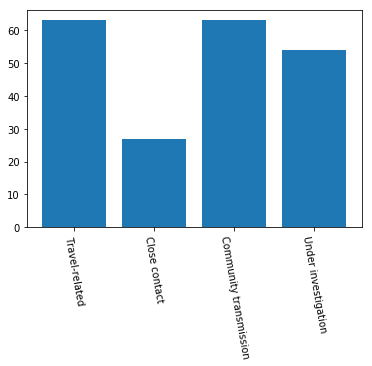

In [223]:
plt.bar(subset.source,subset.number)
plt.xticks(rotation=-80)
plt.show()

#### Total Tests

In [224]:
df = make_df(7)
df

,Testing by Metro Health Laboratory,Number
0,Negative,567
1,Positive,64
2,Inconclusive,1
3,Total tested by Metro Health Lab,632


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
Testing by Metro Health Laboratory    4 non-null object
Number                                4 non-null int64
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


In [226]:
df = df.rename(columns={"Testing by Metro Health Laboratory":"testing","Number":"number"})

In [227]:
subset = df.loc[0:2,]
subset

,testing,number
0,Negative,567
1,Positive,64
2,Inconclusive,1


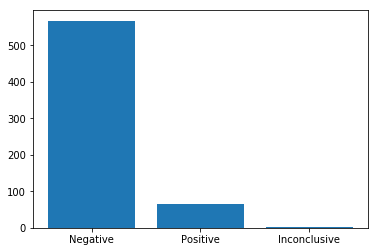

In [228]:
plt.bar(subset.testing,subset.number)
plt.show()

#### Hopitalizations

This one is breaking. 

In [235]:
data = []

table_title = table[1].find('thead')
table_body = table[1].find('tbody')

# create header
rows = table_title.find_all('tr')
for row in rows:
    titles = row.find_all('th')
    header = []
    for title in titles[:2]:
        title = title.text
        title = re.sub('\n\s+',' ',title)
        header.append(title)
        
header

['Medical Visit Type', 'Number']

In [308]:
rows = table_body.find_all('tr')
for row in rows:
    subrows = row.find_all('td')
    for subrow in subrows[:2]:
        subrow = subrow.text
        subrow = re.sub('\s+',' ',subrow) 
        print(subrow)

Not Hospitalized
98
 Drive Through 22 22% Clinic/Provider 31 32% Urgent Care/ Emergency Department 45 46% 
22
22
22%
31
32%
45
46%
Ever Hospitalized
57
 ICU 25 44% On Ventilator 17 30% 
25
25
44%
17
30%


> What kind of monstrosity format is this saved in? 

### Confirmed Cases

#### By Gender

In [309]:
df = make_df(2)
df

,Gender,Number of Cases
0,Male,107
1,Female,100


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
Gender             2 non-null object
Number of Cases    2 non-null int64
dtypes: int64(1), object(1)
memory usage: 160.0+ bytes


In [314]:
df = df.rename(columns={"Gender":"gender","Number of Cases":"number"})

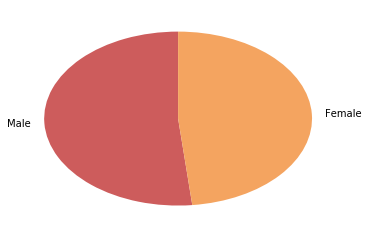

In [342]:
plt.pie(df.number, labels=df.gender, startangle=90, colors=["indianred","sandybrown"] )
plt.show()

#### By Age

In [345]:
df = make_df(3)
df

,Age Group (in years),Number
0,0-19,9
1,20-29,33
2,30-39,26
3,40-49,44
4,50-59,40
5,60-69,31
6,70-79,19
7,80-89,5


In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
Age Group (in years)    8 non-null object
Number                  8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [348]:
df = df.rename(columns={"Age Group (in years)":"age", "Number":"number"})

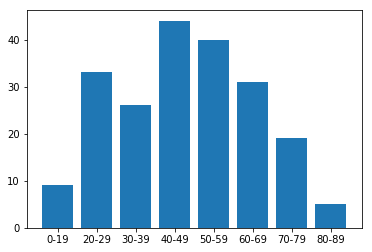

In [351]:
plt.bar(df.age, df.number)
plt.show()

#### Zip Code

This one is also breaking.

In [352]:
# make_df(8)

### Death Case Information

#### Total

In [355]:
df = make_df(4)
df

,Case Status,Number
0,Recovered,44
1,Still Ill,154
2,Deceased,9


In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
Case Status    3 non-null object
Number         3 non-null int64
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


In [357]:
df = df.rename(columns={"Case Status":"status", "Number":"number"})

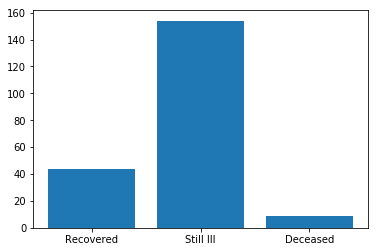

In [359]:
plt.bar(df.status,df.number)
plt.show()

#### By Gender

In [376]:
df = make_df(5)
df

,Gender,Number
0,Male,3
1,Female,6


In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
Gender    2 non-null object
Number    2 non-null int64
dtypes: int64(1), object(1)
memory usage: 160.0+ bytes


In [378]:
df = df.rename(columns={"Gender":"gender","Number":"number"})

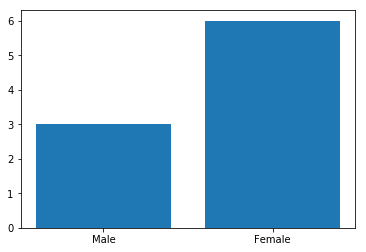

In [379]:
plt.bar(df.gender, df.number)
plt.show()

#### By Age

In [368]:
df = make_df(6)
df

,Age Group (in years),Number
0,0-19,0
1,20-29,0
2,30-39,0
3,40-49,2
4,50-59,3
5,60-69,1
6,70-79,0
7,80-89,3


In [370]:
df = df.rename(columns={"Age Group (in years)":"age","Number":"number"})

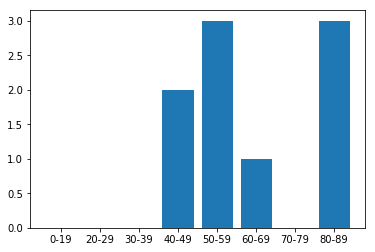

In [372]:
plt.bar(df.age,df.number)
plt.show()